In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import json
import ast
from sklearn.impute import KNNImputer
import geopandas as gpd

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df

,Unnamed: 0,name,url,city,cuisine,avgRating,numReviews,priceRange,latitude,longitude,telephone,postalCode,streetAddress,addressLocality,addressRegion,openingHoursSpecification,addressString,geoString,ratingString
0,0,Market Cafe,https://www.ubereats.com/new-york/food-deliver...,new-york,"['Pizza', 'American', 'Italian']",NaN,NaN,$,40.752349,-73.975021,1.212682e+10,10017,425 Lexington Ave,New York,NY,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.752...",{}
1,1,Dunkin' (850 8th Ave),https://www.ubereats.com/new-york/food-deliver...,new-york,"['Breakfast and Brunch', 'Donuts']",4.1,39.0,$,40.762923,-73.985342,1.212246e+10,10019,850 8th Ave,New York,NY,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.762...","{'@type': 'AggregateRating', 'ratingValue': 4...."
2,2,The Drop,https://www.ubereats.com/new-york/food-deliver...,new-york,"['Coffee and Tea', 'American', 'Breakfast and ...",NaN,NaN,$,40.707828,-74.005660,NaN,10038,111 John Street,New York,NY,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.707...",{}
3,3,Poke Bowl (386 Canal St),https://www.ubereats.com/new-york/food-deliver...,new-york,"['Sushi', 'Asian', 'Japanese']",NaN,NaN,$,40.721287,-74.004971,1.347583e+10,10013,386 Canal St,New York,NY,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.721...",{}
4,4,NOODLE CULTURE,https://www.ubereats.com/new-york/food-deliver...,new-york,"['Chinese', 'Asian', 'Noodles']",NaN,NaN,$,40.740975,-74.004635,1.347990e+10,10014,353 W 14th St,New York,New York,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.740...",{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204,5204,Earle Cafe,https://www.ubereats.com/new-jersey/food-deliv...,newark-new-jersey,"['Middle Eastern', 'Burgers', 'Sandwich', 'Deli']",4.2,88.0,$,40.730331,-74.061955,1.201653e+10,07306,57 Sip Ave,Jersey City,NJ,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.730...","{'@type': 'AggregateRating', 'ratingValue': 4...."
5205,5205,asia garden,https://www.ubereats.com/new-jersey/food-deliv...,newark-new-jersey,"['Chinese', 'Asian', 'Noodles']",NaN,NaN,NaN,40.683170,-74.269190,1.908852e+10,07083,480 Chestnut Street,Union,NJ,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.683...",{}
5206,5206,One Stop Island Grill,https://www.ubereats.com/new-jersey/food-deliv...,newark-new-jersey,"['Caribbean', 'Chicken', 'Seafood']",NaN,NaN,NaN,40.761850,-74.203000,1.862520e+10,07017,188 William Street Floor 1,East Orange,NJ,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.761...",{}
5207,5207,"Rumba Cubana - Clifton, NJ",https://www.ubereats.com/new-jersey/food-deliv...,newark-new-jersey,"['Cuban', 'Caribbean', 'Spanish', 'Latin Ameri...",4.6,500.0,$,40.835567,-74.125035,1.973777e+10,NaN,NaN,NaN,NaN,"[{'@type': 'OpeningHoursSpecification', 'dayOf...",NaN,"{'@type': 'GeoCoordinates', 'latitude': 40.835...","{'@type': 'AggregateRating', 'ratingValue': 4...."


In [4]:
# fix json string quotes 
def fix_json(json_string):
    if type(json_string) == type(""):
        return json_string.replace("'", '"')
    else:
        return json.dumps({'rating': ''})

# fix double quotes for ratingString column
df['ratingString'] = df['ratingString'].apply(lambda x: fix_json(x))

In [5]:
# normalise rating string
df_json = pd.json_normalize(df['ratingString'].apply(json.loads))
df = pd.concat([df, df_json], axis=1)

In [6]:
# convert price range categorical to numerical
def price_range(x):
    if type(x) == type(1.1):
        return 0
    return len(x)
df['priceRange'] = df['priceRange'].apply(price_range)

In [7]:
# standardize addressRegion to one format ex: New York -> NY
def normalise_address_region(x):
    if type(x) == type(''):
        y = x.split(' ')
        if len(y) > 1:
            return ''.join([i[0] for i in y])
        return x
    return x
df['addressRegion'] = df['addressRegion'].apply(normalise_address_region)

In [8]:
# drop unused column
df = df.drop(columns=['Unnamed: 0', 'telephone', 'avgRating', 'numReviews', '@type', 'rating', 'ratingString'])
df.describe()

,priceRange,latitude,longitude,ratingValue
count,5209.000000,5180.000000,5180.000000,2406.000000
mean,1.223075,40.723422,-74.064581,4.513425
std,0.543921,0.102146,0.150811,0.302956
min,0.000000,40.070888,-74.855080,2.700000
25%,1.000000,40.721287,-74.077014,4.400000
50%,1.000000,40.735804,-74.000782,4.600000
75%,1.000000,40.755890,-73.987772,4.700000
max,4.000000,40.926052,-73.908490,5.000000


In [9]:
# check number of rows with na
df.isna().sum()

name                           29
url                             0
city                            0
cuisine                        29
priceRange                      0
latitude                       29
longitude                      29
postalCode                    557
streetAddress                 521
addressLocality               521
addressRegion                 521
openingHoursSpecification      29
addressString                 521
geoString                      29
ratingValue                  2803
reviewCount                  2803
dtype: int64

In [10]:

imputer = KNNImputer(n_neighbors=2)


columns_to_impute = ['ratingValue', 'reviewCount']

# Extract the columns to impute
df_to_impute = df[columns_to_impute]

# use knn to fill Nan values
df_imputed_part = pd.DataFrame(imputer.fit_transform(df_to_impute), columns=columns_to_impute)

In [11]:
df_combined = pd.concat([df_imputed_part, df.drop(columns=columns_to_impute)], axis=1)

In [12]:
# check again for na row count if knn imputed correctly
df_combined.isna().sum()

ratingValue                    0
reviewCount                    0
name                          29
url                            0
city                           0
cuisine                       29
priceRange                     0
latitude                      29
longitude                     29
postalCode                   557
streetAddress                521
addressLocality              521
addressRegion                521
openingHoursSpecification     29
addressString                521
geoString                     29
dtype: int64

In [13]:
df_combined.shape
df = df_combined

In [14]:
df.describe()

,ratingValue,reviewCount,priceRange,latitude,longitude
count,5209.000000,5209.000000,5209.000000,5180.000000,5180.000000
mean,4.513425,132.510391,1.223075,40.723422,-74.064581
std,0.205874,99.040358,0.543921,0.102146,0.150811
min,2.700000,10.000000,0.000000,40.070888,-74.855080
25%,4.513425,81.000000,1.000000,40.721287,-74.077014
50%,4.513425,132.510391,1.000000,40.735804,-74.000782
75%,4.513425,132.510391,1.000000,40.755890,-73.987772
max,5.000000,500.000000,4.000000,40.926052,-73.908490


In [15]:
df.drop_duplicates()
df.shape

(5209, 16)

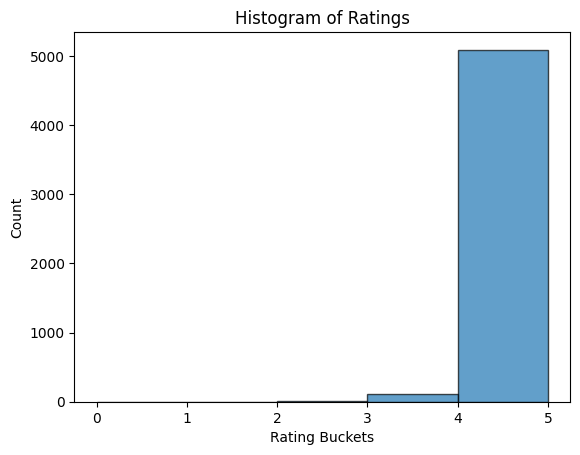

In [16]:
## Plot histogram for ratings
plt.hist(df.ratingValue, bins=[0, 1, 2, 3, 4, 5], edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Rating Buckets')
plt.ylabel('Count')
plt.title('Histogram of Ratings')
plt.show()

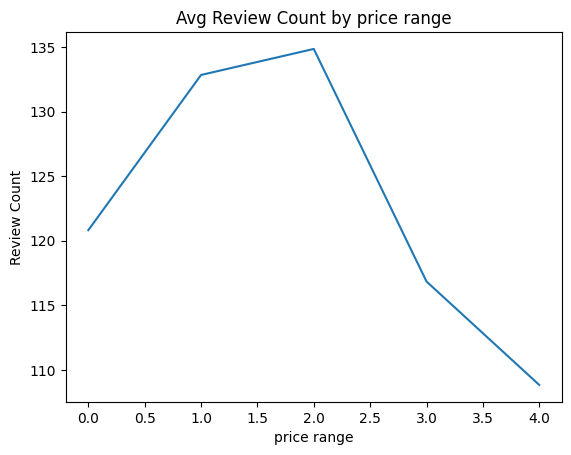

In [17]:
## plot graph for avg review count by price range
grouped_df = df.groupby('priceRange')['reviewCount'].mean().reset_index()
plt.plot(grouped_df['priceRange'], grouped_df['reviewCount'])

# Add title and labels
plt.title('Avg Review Count by price range')
plt.xlabel('price range')
plt.ylabel('Review Count')
plt.savefig('plots/avg_review_count_by_price_range.png')
plt.show()

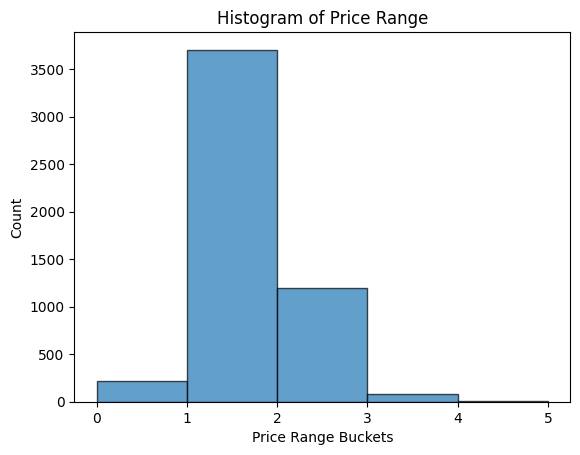

In [18]:
# plot histogram for price range buckets
plt.hist(df.priceRange, bins=[0, 1, 2, 3, 4, 5], edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Price Range Buckets')
plt.ylabel('Count')
plt.title('Histogram of Price Range')
plt.show()

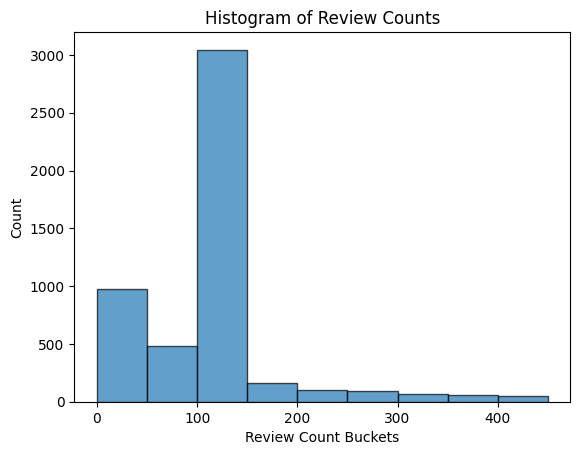

In [19]:
# plot histogram for review counts
plt.hist(df.reviewCount, bins=list(range(0,500,50)), edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Review Count Buckets')
plt.ylabel('Count')
plt.title('Histogram of Review Counts')
plt.show()

In [20]:
from itertools import chain

In [21]:
## cleaning and formating for cuisine feature
set(df.loc[df['cuisine'].notna(), 'cuisine'])

{"['Vegetarian', 'Indian', 'Sandwich']",
 "['Steak', 'Brazilian', 'Healthy']",
 "['Juice and Smoothies', 'Healthy', 'Vegetarian Friendly', 'Healthy']",
 "['Healthy', 'Salads', 'Soup']",
 "['Healthy', 'Vegan', 'Vegetarian Friendly', 'American', 'Gluten Free', 'Desserts']",
 "['American', 'Steak', 'BBQ']",
 "['American', 'Seafood']",
 "['Sandwich', 'Salads', 'Cambodian']",
 "['Breakfast and Brunch', 'Burgers', 'Pasta']",
 "['Asian', 'Thai', 'Noodles']",
 "['Bakery', 'Desserts', 'Kids Friendly']",
 "['Korean', 'Asian Fusion']",
 "['European', 'Hungarian', 'Comfort Food']",
 "['Russian', 'Breakfast and Brunch', 'Juice and Smoothies']",
 "['Desserts', 'Cafe', 'Healthy']",
 "['Korean', 'Chicken', 'Fish and Chips']",
 "['Indian', 'Vegetarian', 'Vegetarian Friendly', 'Family Meals']",
 "['American', 'Sandwich', 'Pastry']",
 "['Lebanese', 'Middle Eastern', 'Mediterranean']",
 "['Japanese', 'Ramen', 'Vegetarian Friendly']",
 "['Chinese', 'Noodles', 'Asian']",
 "['Burgers', 'American', 'Bar Food'

In [22]:
import ast

In [23]:
df = df.dropna(axis=0)
df['cuisine'] = df['cuisine'].apply(ast.literal_eval)

/var/folders/qw/w_wymrtd43767cxrkt3gkr0r0000gn/T/ipykernel_12459/2430375781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cuisine'] = df['cuisine'].apply(ast.literal_eval)


In [24]:
df.shape

(4652, 16)

In [25]:
# create a new feature column based on number of cuisines each restaurant provides
df['cuisine_types'] = df['cuisine'].apply(len)

/var/folders/qw/w_wymrtd43767cxrkt3gkr0r0000gn/T/ipykernel_12459/2843467050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cuisine_types'] = df['cuisine'].apply(len)


In [26]:
set(chain(*df['cuisine']))

{'Afghan',
 'African',
 'African: Other',
 'Alcohol',
 'Allergy Friendly',
 'American',
 'Arabian',
 'Argentinian',
 'Armenian',
 'Asian',
 'Asian Fusion',
 'Asian: Other',
 'Australian',
 'Austrian',
 'BBQ',
 'BREAKfastAndBrunch',
 'Bakery',
 'Bangladeshi',
 'Bar / Pub Food',
 'Bar Food',
 'Belgian',
 'Biryani',
 'Brazilian',
 'Breakfast',
 'Breakfast & Brunch',
 'Breakfast and Brunch',
 'British',
 'Brunch',
 'Bubble Tea',
 'Burgers',
 'Burritos',
 'Cafe',
 'Cajun',
 'Cambodian',
 'Cantonese',
 'Caribbean',
 'Chicken',
 'Chicken Strips',
 'ChickenRice',
 'Chilean',
 'Chinese',
 'Chinese Food',
 'Chinese: Cantonese',
 'Chinese: Noodles & Dumplings',
 'Chinese: Other',
 'Chinese: Sichuan',
 'Chinese: Taiwanese',
 'ChineseNoodles',
 'Coffee & Tea',
 'Coffee and Tea',
 'Colombian',
 'Comfort Food',
 'CongeeBoilRice',
 'Convenience',
 'Cuban',
 'Cupcakes',
 'Curry',
 'CurryRice',
 'Danish',
 'Deli',
 'Dessert: Other',
 'Desserts',
 'Diner',
 'Dinner',
 'Dominican',
 'Donuts',
 'Dumplings'

In [27]:
# more cleaning for cuisines
def lower_case(x):
    return [i.lower() for i in x]
df['cuisine'] = df['cuisine'].apply(lower_case)

/var/folders/qw/w_wymrtd43767cxrkt3gkr0r0000gn/T/ipykernel_12459/2564162413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cuisine'] = df['cuisine'].apply(lower_case)


In [28]:
# merge cuisines with same prefix
def remove_duplicates_with_same_prefix(lst):
    result = {}
    
    for string in lst:
        prefix = next((key for key in result if string.startswith(key)), None)
        
        if prefix is not None:
            if len(string) < len(result[prefix]):
                result[prefix] = string
        else:
            st = string.split(' ')[0]
            result[st] = st 

    return list(result.values())

In [29]:
cuisines = remove_duplicates_with_same_prefix(sorted(list(set(chain(*df['cuisine'])))))

In [30]:
# normalise the cuisines
def normalise_cuisins(x):
    return [i for i in cuisines for j in x if j.startswith(i)]
        
df['cuisine'] = df['cuisine'].apply(normalise_cuisins)

/var/folders/qw/w_wymrtd43767cxrkt3gkr0r0000gn/T/ipykernel_12459/166085296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cuisine'] = df['cuisine'].apply(normalise_cuisins)


In [31]:
df_exploded = df.explode('cuisine')

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

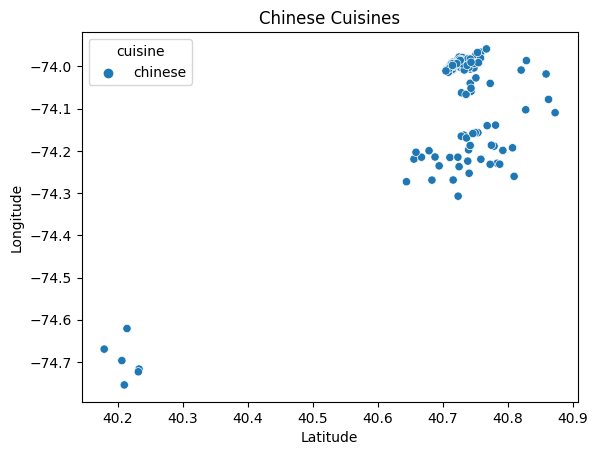

In [32]:
# plot graph to visualise the chinese restaurants by location
df_filtered = df_exploded[df_exploded['cuisine'].isin(['chinese'])]

sb.scatterplot(data=df_filtered, x='latitude', y='longitude', hue='cuisine')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Chinese Cuisines')
plt.savefig('plots/chinese_cuisine_distribution.png')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

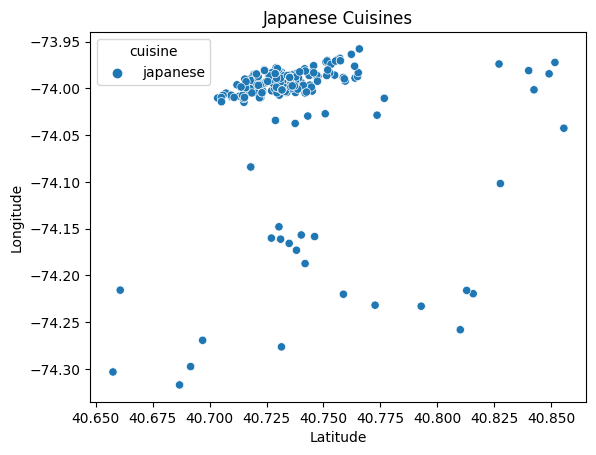

In [33]:
# plot graph to visualise the japanes restaurants by location
df_filtered = df_exploded[df_exploded['cuisine'].isin(['japanese'])]

sb.scatterplot(data=df_filtered, x='latitude', y='longitude', hue='cuisine')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Japanese Cuisines')
plt.savefig('plots/japanese_cuisine_distribution.png')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

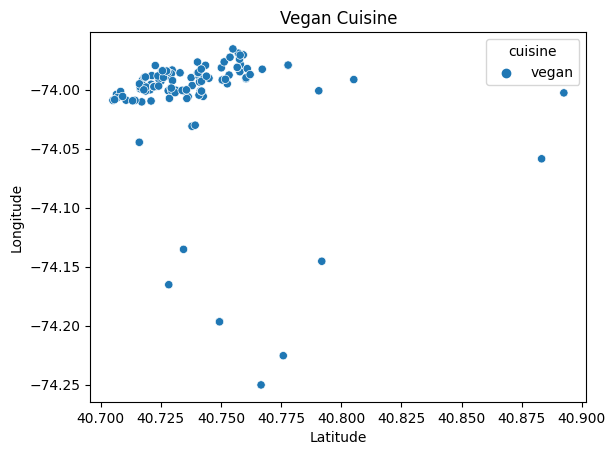

In [34]:
# plot graph to visualise the vegan restaurants by location
df_filtered = df_exploded[df_exploded['cuisine'].isin([ 'vegan'])]

sb.scatterplot(data=df_filtered, x='latitude', y='longitude', hue='cuisine')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Vegan Cuisine')
plt.savefig('plots/vegan_cuisine_distribution.png')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

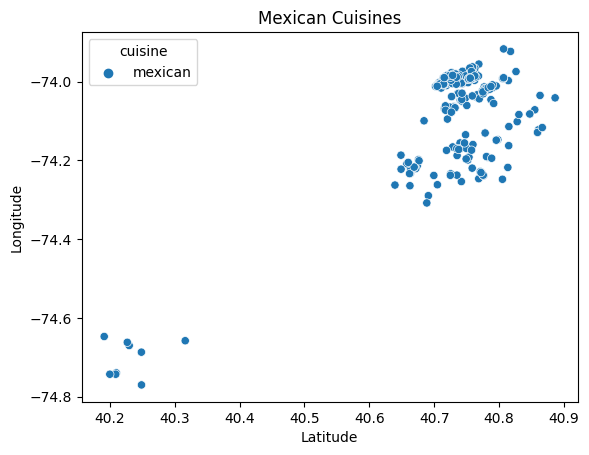

In [35]:
# plot graph to visualise the mexican restaurants by location
df_filtered = df_exploded[df_exploded['cuisine'].isin(['mexican'])]

sb.scatterplot(data=df_filtered, x='latitude', y='longitude', hue='cuisine')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Mexican Cuisines')
plt.savefig('plots/mexican_cuisine_distribution.png')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

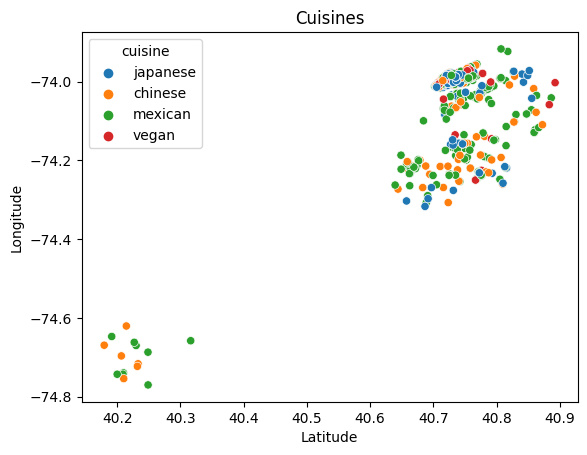

In [36]:
# plot graph to visualise the restaurants by location and cuisine
df_filtered = df_exploded[df_exploded['cuisine'].isin(['chinese', 'japanese', 'vegan', 'mexican'])]

sb.scatterplot(data=df_filtered, x='latitude', y='longitude', hue='cuisine')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Cuisines')
plt.savefig('plots/cuisines.png')
plt.show()

In [37]:
df_dummies = pd.get_dummies(df_exploded['cuisine'], prefix='').groupby(level=0).sum()
df_result = pd.concat([df, df_dummies], axis=1)
df_result = df_result.drop('cuisine', axis=1)

In [38]:
df_result.describe()

,ratingValue,reviewCount,priceRange,latitude,longitude,cuisine_types,_afghan,_african,_alcohol,_allergy,...,_traditional,_turkish,_vegan,_vegetarian,_venezuelan,_vietnamese,_west,_whatever,_wings,_wraps
count,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,...,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000
mean,4.515611,132.717637,1.230224,40.725458,-74.059734,3.157997,0.000430,0.004729,0.000645,0.024936,...,0.007524,0.003224,0.027300,0.092648,0.000430,0.007094,0.001505,0.000645,0.044712,0.000430
std,0.204469,99.947998,0.531613,0.097441,0.144937,1.336750,0.020732,0.068613,0.025389,0.155945,...,0.086421,0.056698,0.175672,0.304439,0.020732,0.083934,0.038766,0.025389,0.206693,0.020732
min,2.700000,10.000000,0.000000,40.070888,-74.855080,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.513425,79.750000,1.000000,40.721655,-74.063913,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.513425,132.510391,1.000000,40.735934,-73.999916,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.513425,132.510391,1.000000,40.756092,-73.987487,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,500.000000,4.000000,40.909039,-73.908490,20.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


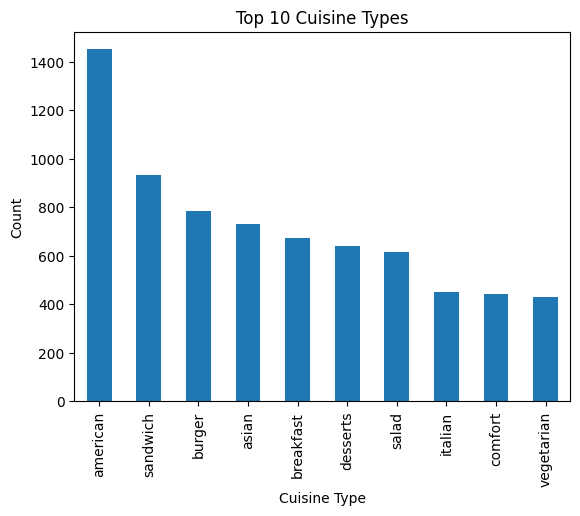

In [39]:
cuisine_counts = df_exploded['cuisine'].value_counts()

# Select the top 10 cuisine types
top_cuisines = cuisine_counts.head(10)

# Plot a bar graph
top_cuisines.plot(kind='bar')
plt.xlabel('Cuisine Type')
plt.ylabel('Count')
plt.title('Top 10 Cuisine Types')
plt.savefig('plots/top_10_cuisines.png')
plt.show()

In [40]:
count = []
new_cuisines = []
for ci in ["_"+x for x in cuisines]:
    val = df_result[ci].sum()
    if val >= 10:
        new_cuisines.append(ci)
        count.append(val)
    print(f"Freq {ci}: {df_result[ci].sum()}")

Freq _afghan: 2
Freq _african: 22
Freq _alcohol: 3
Freq _allergy: 116
Freq _american: 1450
Freq _arabian: 13
Freq _argentinian: 8
Freq _armenian: 1
Freq _asian: 730
Freq _australian: 4
Freq _austrian: 1
Freq _bakery: 146
Freq _bangladeshi: 2
Freq _bar: 62
Freq _bbq: 97
Freq _belgian: 6
Freq _biryani: 1
Freq _brazilian: 29
Freq _breakfast: 672
Freq _british: 1
Freq _brunch: 1
Freq _bubble: 55
Freq _burger: 786
Freq _burritos: 38
Freq _cafe: 107
Freq _cajun: 9
Freq _cambodian: 2
Freq _cantonese: 7
Freq _caribbean: 55
Freq _chicken: 249
Freq _chilean: 1
Freq _chinese: 215
Freq _chocolatier: 13
Freq _coffee: 224
Freq _colombian: 18
Freq _comfort: 442
Freq _congeeboilrice: 2
Freq _convenience: 17
Freq _cuban: 38
Freq _cupcakes: 19
Freq _curry: 9
Freq _danish: 1
Freq _deli: 86
Freq _dessert:: 3
Freq _desserts: 641
Freq _diner: 48
Freq _dinner: 13
Freq _dominican: 11
Freq _donuts: 196
Freq _dumplings: 3
Freq _eastern: 4
Freq _egyptian: 2
Freq _ethiopian: 3
Freq _european: 35
Freq _everyday: 1

In [41]:
df = df_result
geometry = gpd.points_from_xy(df['longitude'], df['latitude'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

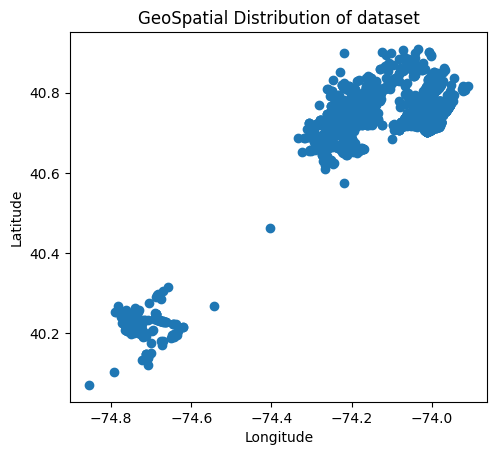

In [42]:
gdf.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GeoSpatial Distribution of dataset')
plt.savefig('plots/geospatial_dataset.png')
plt.show()

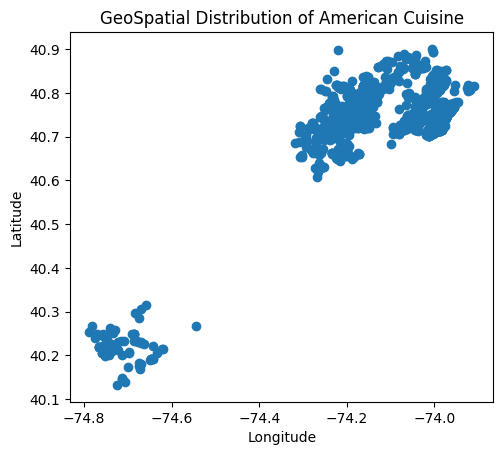

In [43]:
american = df[df['_american'] == 0]
geometry = gpd.points_from_xy(american['longitude'], american['latitude'])
gdf = gpd.GeoDataFrame(american, geometry=geometry)
gdf.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GeoSpatial Distribution of American Cuisine')
plt.savefig('plots/american_cuisine.png')
plt.show()


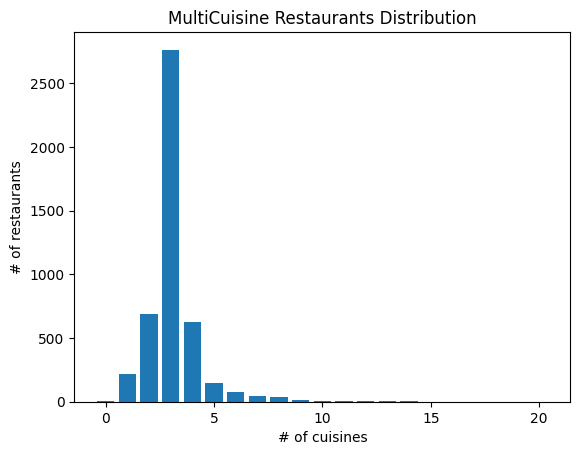

In [44]:
# plot graph for restaurants distribution by cusine count 
cuisine_types = df['cuisine_types'].value_counts().sort_index()
plt.bar(cuisine_types.index, cuisine_types)
plt.xlabel('# of cuisines')
plt.ylabel('# of restaurants')
plt.title('MultiCuisine Restaurants Distribution')
plt.savefig('plots/cuisines_counts.png')
plt.show()

In [45]:
df.describe()

,ratingValue,reviewCount,priceRange,latitude,longitude,cuisine_types,_afghan,_african,_alcohol,_allergy,...,_traditional,_turkish,_vegan,_vegetarian,_venezuelan,_vietnamese,_west,_whatever,_wings,_wraps
count,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,...,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000
mean,4.515611,132.717637,1.230224,40.725458,-74.059734,3.157997,0.000430,0.004729,0.000645,0.024936,...,0.007524,0.003224,0.027300,0.092648,0.000430,0.007094,0.001505,0.000645,0.044712,0.000430
std,0.204469,99.947998,0.531613,0.097441,0.144937,1.336750,0.020732,0.068613,0.025389,0.155945,...,0.086421,0.056698,0.175672,0.304439,0.020732,0.083934,0.038766,0.025389,0.206693,0.020732
min,2.700000,10.000000,0.000000,40.070888,-74.855080,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.513425,79.750000,1.000000,40.721655,-74.063913,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.513425,132.510391,1.000000,40.735934,-73.999916,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.513425,132.510391,1.000000,40.756092,-73.987487,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,500.000000,4.000000,40.909039,-73.908490,20.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
# remove outliers
df = df[df['cuisine_types'] <= 8]
df = df[df['cuisine_types'] > 0]
df = df[df['priceRange'] > 0]

In [47]:
# drop unused features
df = df.drop(columns=['name', 'url', 'city', 'streetAddress', 'postalCode', 'addressLocality', 'addressRegion', 'openingHoursSpecification', 'addressString', 'geoString'])

In [48]:
df.select_dtypes(include='object').columns


Index([], dtype='object')

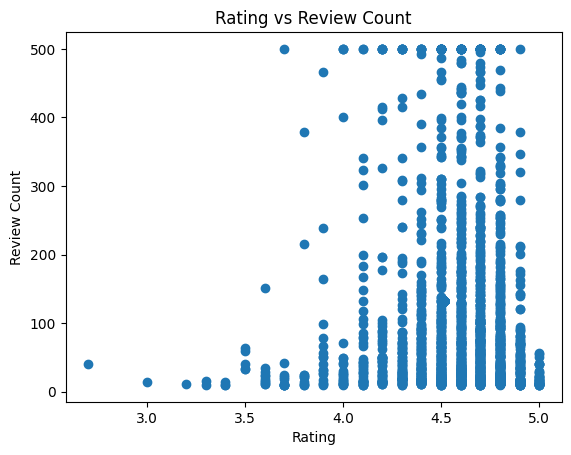

In [49]:

corr_columns = ['ratingValue', 'reviewCount', 'priceRange']

# plot graph for ratings & reviews for american cuisine
plt.scatter(american['ratingValue'], american['reviewCount'])
plt.xlabel('Rating')
plt.ylabel('Review Count')
plt.title('Rating vs Review Count')
plt.savefig('plots/rating_review_count.png')
plt.show()

In [50]:
# view correlation matrix of all features
df.corr()

,ratingValue,reviewCount,priceRange,latitude,longitude,cuisine_types,_afghan,_african,_alcohol,_allergy,...,_traditional,_turkish,_vegan,_vegetarian,_venezuelan,_vietnamese,_west,_whatever,_wings,_wraps
ratingValue,1.000000,-0.000779,0.072250,0.073711,0.108743,0.016678,-0.000234,-0.006265,-0.000286,0.006356,...,-0.004783,0.005843,0.052163,0.046777,0.009320,0.022461,-0.007719,NaN,-0.120665,-0.000234
reviewCount,-0.000779,1.000000,-0.008399,0.089068,-0.059790,0.026044,-0.000055,-0.029489,-0.000067,-0.045387,...,0.003711,-0.017469,-0.045127,-0.070069,-0.009812,-0.035442,0.004716,NaN,0.079585,-0.000055
priceRange,0.072250,-0.008399,1.000000,0.052161,0.072781,-0.041812,0.009800,-0.025388,0.003118,0.000427,...,0.039079,0.022898,0.003429,-0.006043,-0.011963,-0.005565,0.008616,NaN,0.014800,0.009800
latitude,0.073711,0.089068,0.052161,1.000000,0.780127,-0.002344,0.004984,0.002714,0.002477,0.020636,...,-0.002303,0.022843,0.023662,0.006229,0.001179,0.003516,0.007595,NaN,-0.057434,0.000008
longitude,0.108743,-0.059790,0.072781,0.780127,1.000000,0.009870,0.012579,-0.033669,0.011809,0.000709,...,0.004130,0.028115,0.054322,0.066159,0.009682,0.032684,-0.022449,NaN,-0.114038,0.008483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_vietnamese,0.022461,-0.035442,-0.005565,0.003516,0.032684,0.001221,-0.001719,-0.005582,-0.002106,0.024198,...,-0.006334,-0.004714,-0.012467,-0.015075,-0.001719,1.000000,-0.002719,NaN,-0.017167,-0.001719
_west,-0.007719,0.004716,0.008616,0.007595,-0.022449,0.028922,-0.000712,0.095565,-0.000872,-0.005218,...,-0.002623,-0.001952,-0.005163,-0.010186,-0.000712,-0.002719,1.000000,NaN,-0.007109,-0.000712
_whatever,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_wings,-0.120665,0.079585,0.014800,-0.057434,-0.114038,0.130228,-0.004495,-0.014596,-0.005505,-0.011036,...,0.011994,-0.012327,-0.025824,-0.045414,-0.004495,-0.017167,-0.007109,NaN,1.000000,-0.004495


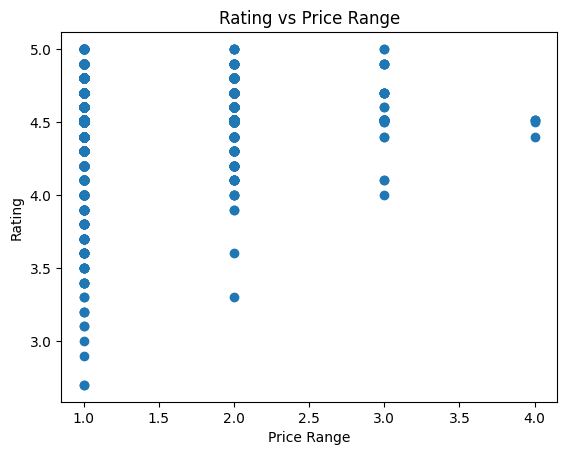

In [51]:
# plot graph for price range and rating
plt.scatter(df['priceRange'], df['ratingValue'])

plt.ylabel('Rating')
plt.xlabel('Price Range')
plt.title('Rating vs Price Range')
plt.savefig('plots/rating_price_range.png')
plt.show()

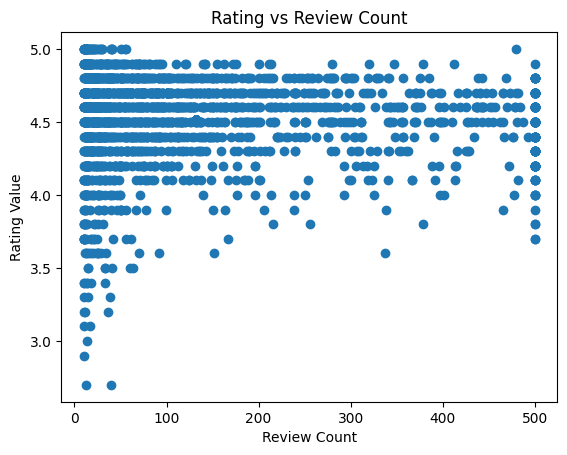

In [52]:
# plot graph for review counts and rating
plt.scatter(df['reviewCount'], df['ratingValue'])

plt.ylabel('Rating Value')
plt.xlabel('Review Count')
plt.title('Rating vs Review Count')
plt.savefig('plots/rating_review_count.png')
plt.show()

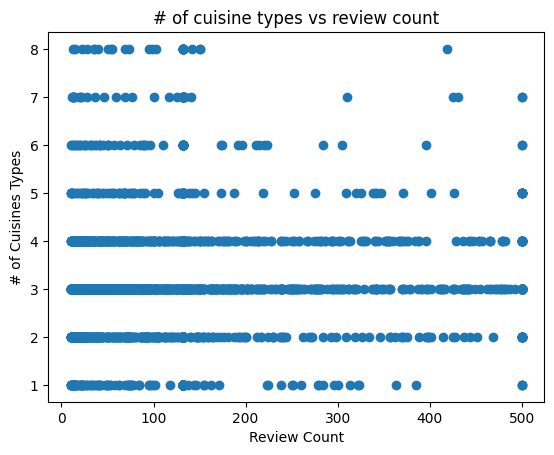

In [53]:
# plot graph for review counts and cuisine types
plt.scatter(df['reviewCount'], df['cuisine_types'])

plt.ylabel('# of Cuisines Types')
plt.xlabel('Review Count')
plt.title('# of cuisine types vs review count')
plt.savefig('plots/cuisines_review_counts.png')
plt.show()

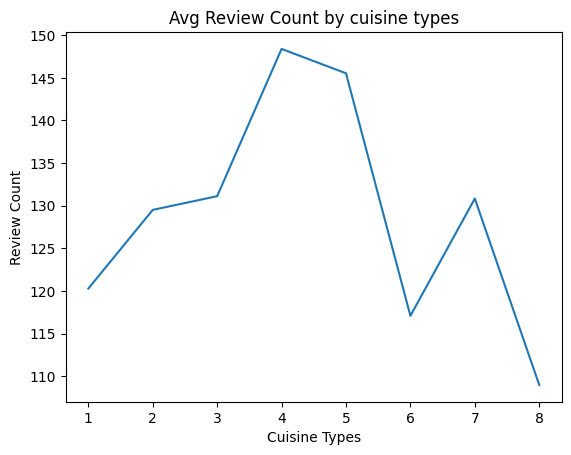

In [54]:
grouped_df = df.groupby('cuisine_types')['reviewCount'].mean().reset_index()


# Plot the graph for avg review counts by cuisine count
plt.plot(grouped_df['cuisine_types'], grouped_df['reviewCount'])

# Add title and labels
plt.title('Avg Review Count by cuisine types')
plt.xlabel('Cuisine Types')
plt.ylabel('Review Count')
plt.savefig('plots/avg_review_count_by_cuisine_types.png')
plt.show()

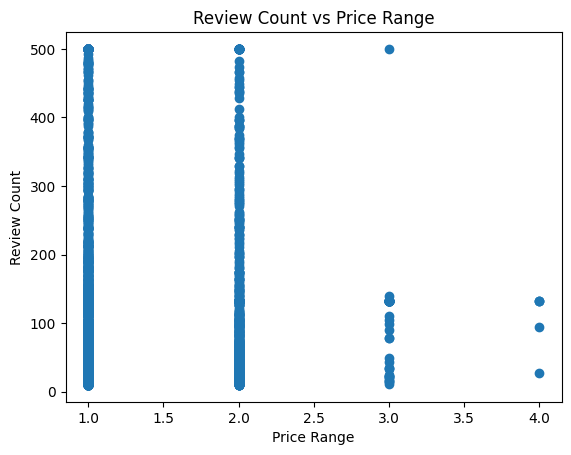

In [55]:
# plot graph for price range and review counts
plt.scatter(df['priceRange'], df['reviewCount'])
plt.ylabel('Review Count')
plt.xlabel('Price Range')
plt.title('Review Count vs Price Range')
plt.savefig('plots/price_range_review_count.png')
plt.show()

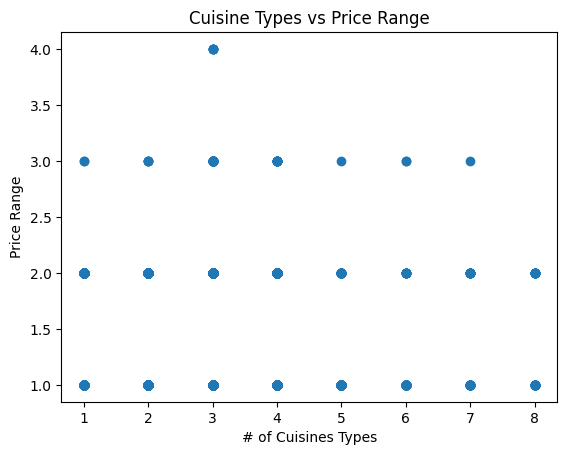

In [56]:
# plot for cuisine types and price range
plt.scatter(df['cuisine_types'], df['priceRange'])

plt.xlabel('# of Cuisines Types')
plt.ylabel('Price Range')
plt.title('Cuisine Types vs Price Range')
plt.savefig('plots/price_range_cuisine_types.png')
plt.show()

In [57]:
# normalise the features
df = (df - df.min()) / (df.max() - df.min())

In [58]:
corr_columns = ['ratingValue', 'reviewCount', 'priceRange', 'cuisine_types']
corr_matrix = df[corr_columns].corr()

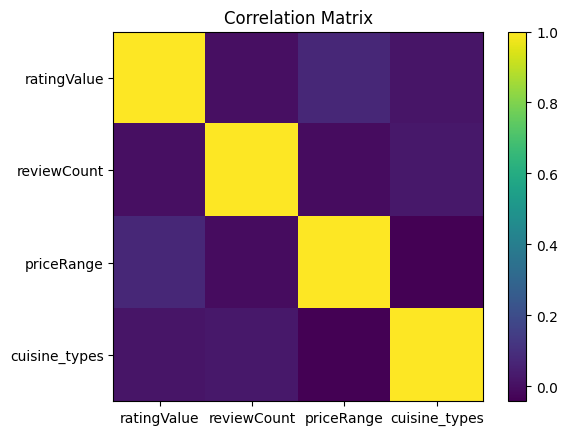

In [59]:
# plot correlation matrix for selected features
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_columns)), corr_columns)
plt.yticks(range(len(corr_columns)), corr_columns)
plt.title('Correlation Matrix')
plt.savefig('plots/correlation_matrix.png')
plt.show()